In [1]:
# Uncomment the following to install Python denpendencies
! pip install osmnx pystac-client odc-stac rioxarray geopandas matplotlib

  Using cached osmnx-1.9.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached pystac_client-0.7.6-py3-none-any.whl.metadata (5.2 kB)
  Using cached odc_stac-0.3.9-py3-none-any.whl.metadata (4.5 kB)
  Using cached geopandas-0.14.3-py3-none-any.whl.metadata (1.5 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached shapely-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
  Using cached pystac-1.10.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached odc_geo-0.4.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached rasterio-1.3.9-cp310-cp310-manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached dask-2024.4.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached too

In [2]:
import osmnx as ox

# Get polygon of Rhodes Isaland
rhodes = ox.geocode_to_gdf("Rhodes")

# Inspect the Geodataframe
rhodes

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((27.68357 36.15271, 27.68378 36...",36.458283,35.876662,28.247628,27.683572,371538319,relation,452614,36.17253,27.919402,place,island,17,0.60392,island,Rhodes,"Rhodes, Aegean, Greece"


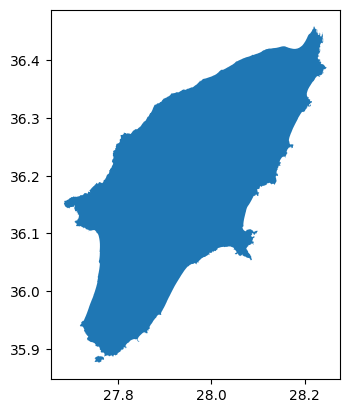

In [3]:
# Visualize the polygon
rhodes.plot()

# Save the polygon to a GeoPackage file
rhodes.to_file("rhodes.gpkg")

In [4]:
from pystac_client import Client 

# Setup search client from a URL
# The URL of the data provider can be found at STAC Browser:
# https://radiantearth.github.io/stac-browser/#/
api_url = 'https://earth-search.aws.element84.com/v1'
client = Client.open(api_url)

# Setup collection
# One can check the available collections by walking through the collections:
# [collection for collection in client.get_collections()]
collection = 'sentinel-2-l2a'  # Sentinel-2, Level 2A

# Get the search geometry from the GeoDataFrame
# We select the "geometry" column and the first row (there is only one row)
polygon = rhodes['geometry'].iloc[0]

# Construct the search
search = client.search(
    collections=[collection],
    intersects=polygon,
    datetime='2023-07-01/2023-08-31', # date range for the search
    query=['eo:cloud_cover<10'] # cloud cover less than 1%
)

# inspect the search results
items = search.item_collection()
len(items) # Inspect how many items are found

# Save search results
items.save_object('rhodes_sentinel-2.json')

In [5]:
import odc.stac

# bands of interest
bands = ["red", "green", "blue", "nir", "swir16", "swir22"]

# Load the search results as xarray.Dataset
# This load will be lazy, so the data is not yet loaded into memory 
ds = odc.stac.load(
    items,
    groupby="solar_day", # group the image with the same solar day
    bands=bands,
    resolution=40, # loading resolution
    chunks={"x": 2048, "y": 2048}, # specify the chunk size for Dask
)

# Inspect the loaded dataset
ds

<xarray.Dataset> Size: 8GB
Dimensions:      (y: 5246, x: 5246, time: 25)
Coordinates:
  * y            (y) float64 42kB 4.1e+06 4.1e+06 4.1e+06 ... 3.89e+06 3.89e+06
  * x            (x) float64 42kB 5e+05 5e+05 5.001e+05 ... 7.097e+05 7.098e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
Data variables:
    red          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [6]:
# Import the rioxarray library to use the "rio" extension
import rioxarray 

# Compute the bounding box of Rhodes
rhodes_reprojected = rhodes.to_crs(ds.rio.crs) # reproject the polygon to the same CRS as the dataset
bbox = rhodes_reprojected.total_bounds

# First, crop the dataset to the bounding box of Rhodes
# Then clip the dataset to the polygon of Rhodes
ds_rhodes = ds.rio.clip_box(*bbox)
ds_rhodes = ds_rhodes.rio.clip(rhodes_reprojected.geometry)
ds_rhodes

<xarray.Dataset> Size: 614MB
Dimensions:      (y: 1624, x: 1260, time: 25)
Coordinates:
  * y            (y) float64 13kB 4.035e+06 4.035e+06 ... 3.971e+06 3.971e+06
  * x            (x) float64 10kB 5.615e+05 5.615e+05 ... 6.118e+05 6.119e+05
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    red          (time, y, x) uint16 102MB dask.array<chunksize=(1, 434, 510), meta=np.ndarray>
    green        (time, y, x) uint16 102MB dask.array<chunksize=(1, 434, 510), meta=np.ndarray>
    blue         (time, y, x) uint16 102MB dask.array<chunksize=(1, 434, 510), meta=np.ndarray>
    nir          (time, y, x) uint16 102MB dask.array<chunksize=(1, 434, 510), meta=np.ndarray>
    swir16       (time, y, x) uint16 102MB dask.array<chunksize=(1, 434, 510), meta=np.ndarray>
    swir22       (time, y, x) uint16 102MB dask.array<chunksize=(1, 434, 510), meta=np.ndarray>

/home/oku/miniforge3/envs/sc_egu24/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/oku/miniforge3/envs/sc_egu24/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


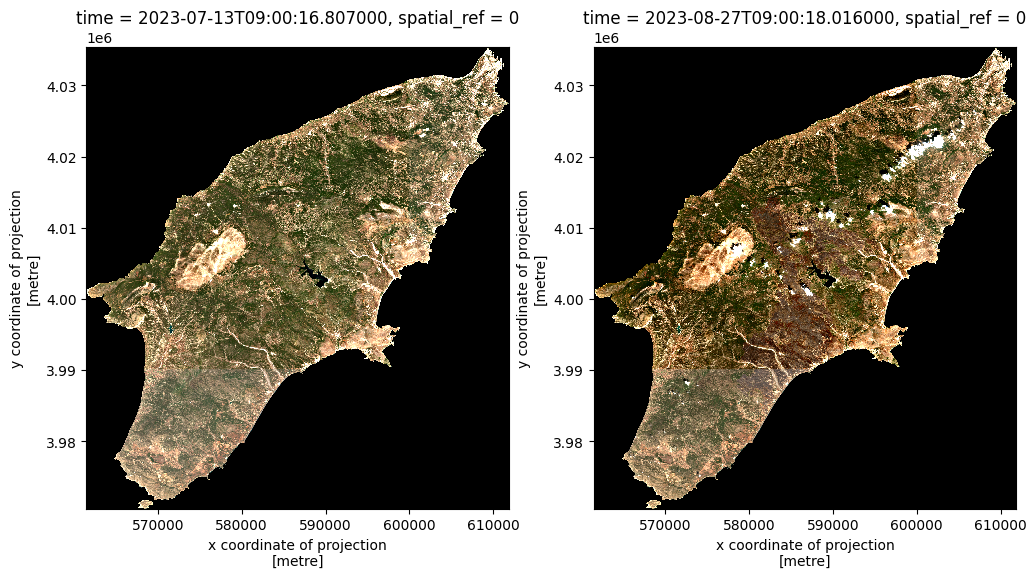

In [7]:
from matplotlib import pyplot as plt

# Select before and after the wild fire
ds_before = ds_rhodes.sel(time="2023-07-13", method="nearest")
ds_after = ds_rhodes.sel(time="2023-08-27", method="nearest")

# Define a function to create a true color image
def rgb_img(ds):
    ds_rgb = ds[["red", "green", "blue"]].to_array()

    # Sentiel-2 L2A data provides Bottom of Atmosphere (BOA) reflectance times 10,000
    # In some cases, the reflectance values are larger than 10000 for some bright relections
    # For simplicity, we set all values larger than 10000 to 10000
    # Then we scale the reflectance to 0-255
    ds_rgb = ds_rgb.where(ds_rgb <= 10000, 10000)
    img = (ds_rgb / 10_000 * 255).astype("int")
    return img

# Visualize the true color image before and after the wild fire
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
rgb_img(ds_before).plot.imshow(ax = axs[0], robust=True) # Use robust=True to contrast the image
rgb_img(ds_after).plot.imshow(ax = axs[1], robust=True)

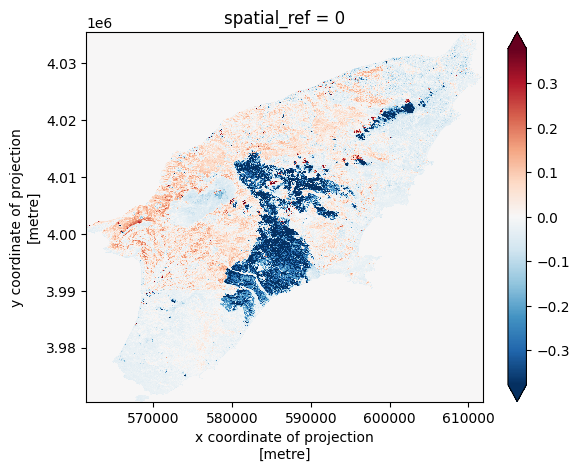

In [8]:
# Calculate NDVI before and after the wild fire
ndvi_before = (ds_before["nir"] - ds_before["red"]) / (ds_before["nir"] + ds_before["red"])
ndvi_before = ndvi_before.where(ndvi_before <= 1, 0)
ndvi_after = (ds_after["nir"] - ds_after["red"]) / (ds_after["nir"] + ds_after["red"])
ndvi_after = ndvi_after.where(ndvi_after <= 1, 0)

# Calculate the difference of NDVI before and after the wild fire
ndvi_diff = ndvi_after - ndvi_before

# Visualize the NDVI difference
ndvi_diff.plot.imshow(robust=True)

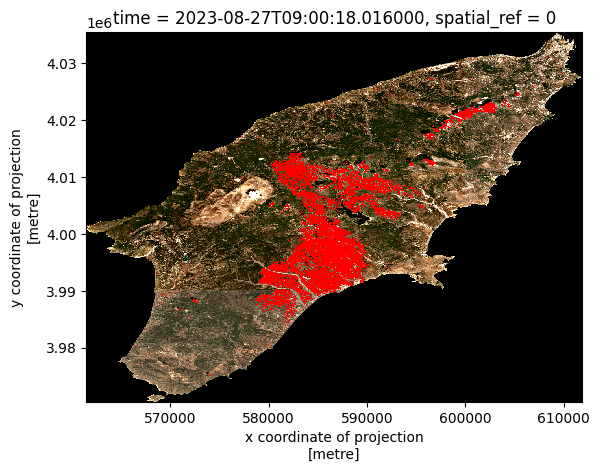

In [9]:
# If NDVI drops more than 0.2, consider it as a vegetation damage
# Note this is not a scientific threshold, since cloud coverage can also cause NDVI change
# For simplicity, we use this threshold to demonstrate the process
# We will create a burned index map and mark the burned area with 1
burned_index = ndvi_diff < -0.2

# Then visualize the burned index map over the true color image after the wild fire
burned_image = rgb_img(ds_after) # Build a true color image
burned_image[0] = burned_image[0].where(~burned_index, 255) # Mark the burned area with red
burned_image[1:3] = burned_image[1:3].where(~burned_index, 0) # Exclude the green and blue channel at burned location
burned_image.plot.imshow(robust=True)